<a href="https://colab.research.google.com/github/ggarg23/DEXTER-ROUND-1/blob/master/6_BatchNormalization_Regularization/Experiments/BatchNorm/BN_FInal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from collections import OrderedDict
from itertools import product

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

from torch.optim.lr_scheduler import StepLR,OneCycleLR

In [27]:
class Net(nn.Module):
    def __init__(self,norm_type='BN',dropout_value = 0.01):
        super(Net, self).__init__()
        self.conv1 = self.conv2d(1, 8, 3,norm_type,dropout_value,2)
        self.conv2 = self.conv2d(8, 16, 3,norm_type,dropout_value,4) 
        
        #Transition Block
        self.trans1 = nn.Sequential(
            
            nn.MaxPool2d(2, 2), #  Input 24x24 output 12x12 RF : 6x6
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False)  # Input 12x12 output 12x12 RF : 6x6
        )
        
        self.conv3 = self.conv2d(8, 16, 3,norm_type,dropout_value,4) 
        self.conv4 = self.conv2d(16, 16, 3,norm_type,dropout_value,4) 
        self.conv5 = self.conv2d(16, 16, 3,norm_type,dropout_value,4) 
        self.avgpool2d = nn.AvgPool2d(kernel_size=6)
        self.conv6 =  self.conv2d(16, 16, 1,norm_type,dropout_value,4) 
        self.conv7 = nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False) 

    def conv2d(self, in_channels, out_channels, kernel_size, norm_type, dropout,num_of_groups):
        if norm_type == "BN":
         conv = nn.Sequential(OrderedDict([
                ('conv2d', nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,padding=0, bias=False)),
                ('Relu', nn.ReLU()),
                ('BatchNorm',nn.BatchNorm2d(out_channels)),
                ('Dropout', nn.Dropout(dropout))
         ]))
        elif norm_type == "LN":
            conv = nn.Sequential(OrderedDict([
                ('conv2d',nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=0, bias=False)),
                ('Relu', nn.ReLU()),
                ## When number of groups is 1, its layernorm
                ('LayerNorm',nn.GroupNorm(1,out_channels)),
                ('Dropout',nn.Dropout(dropout))
            ]))
        elif norm_type == "GN":
            conv = nn.Sequential(OrderedDict([
                ('conv2d',nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=0, bias=False)),
                ('Relu', nn.ReLU()),
                ('GroupNorm',nn.GroupNorm(num_of_groups,out_channels)),
                ('Dropout',nn.Dropout(dropout))
            ]))
        else:
            conv = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=0, bias=False),
                nn.ReLU(),
                nn.Dropout(dropout)
            )
      
        return conv

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.trans1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool2d(x)
        x = self.conv6(x)
        x = self.conv7(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [28]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net('BN',0.01).to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

In [31]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-6.0, 6.0), fill=(1,)),                
                                       transforms.RandomAffine(degrees=7, shear=7, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                                       transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.40, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [48]:
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [49]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
#dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
#train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
#test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [50]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch,train_acc,train_loss,lambda_l1,scheduler):

  model.train()
  pbar = tqdm(train_loader)
  
  correct = 0
  processed = 0
  
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    
    #L1 Regularization
    if lambda_l1 > 0:
      l1 = 0
      for p in model.parameters():
        l1 = l1 + p.abs().sum()
      loss = loss + lambda_l1*l1

    train_loss.append(loss.data.cpu().numpy().item())

    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

    


In [51]:

def test(model, device, test_loader,test_acc,test_losses):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))




In [56]:
def experiments(train_loader, test_loader, norm_type, l1_factor, l2_factor, dropout, epochs, batchSize):
    
    train_losses = []
    test_losses = []
    train_accuracy = []
    test_accuracy = []
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
  
    model = Net(norm_type, dropout).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.015, momentum=0.7,weight_decay=l2_factor)
    scheduler = OneCycleLR(optimizer, max_lr=0.015,epochs=epochs,steps_per_epoch=len(train_loader))
    epochs = epochs

    for epoch in range(1, epochs + 1):
      print(f'Epoch {epoch}:')
      train(model, device, train_loader, optimizer, epoch, train_accuracy, train_losses, l1_factor,scheduler)
      test(model, device, test_loader,test_accuracy,test_losses)

    return (train_accuracy,train_losses,test_accuracy,test_losses),model

In [ ]:
'''exp = {  
    'BatchNorm':[]
    'BatchNorm+L1':['BN',0.002,0]
}'''
parameters = dict(
    batch_size = [64,128]
    ,l1 = [0, .001, .002]
    ,l2 = [0, .001, .002]
)

param_values = [v for v in parameters.values()]

for batch_size, l1, l2 in product(*param_values): 
  exp_metrics = {}
  dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
  train_loader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)
  test_loader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)
  print('\n' +'\033[1m' + '=====================================Model Training for batch size:  ' + str(batch_size) + ',l1:  '+ str(l1) + ',l2: '+str(l2) +'======================================================'+'\033[0m\n')
  (exp_metrics['BN']),model = experiments(train_loader, test_loader,'BN',l1,l2,0.03,20,batch_size)
  torch.save(model, './{}.pt'.format('BN_'+str(batch_size) + 'l1_'+ str(l1) + ',l2_'+str(l2)))

'''for e in exp.items():
  print('\n' +'\033[1m' + '=====================================Model Training for '+ f'{e[0]} ======================================================'+'\033[0m\n')
  (exp_metrics[e[0]]),model = experiments(train_loader, test_loader,'BN',e[1][1],e[1][2],0.03,20)
  torch.save(model, './{}.pt'.format(e[0]))'''



  0%|          | 0/938 [00:00<?, ?it/s]


=====================================Model Training for batch size:  64,l1:  0,l2: 0======================================================

Epoch 1:




Loss=2.5211594104766846 Batch_id=0 Accuracy=7.81:   0%|          | 0/938 [00:00<?, ?it/s]

Loss=2.5211594104766846 Batch_id=0 Accuracy=7.81:   0%|          | 1/938 [00:00<03:10,  4.93it/s]

Loss=2.3246405124664307 Batch_id=1 Accuracy=10.16:   0%|          | 1/938 [00:00<03:10,  4.93it/s]

Loss=2.446669578552246 Batch_id=2 Accuracy=10.94:   0%|          | 1/938 [00:00<03:10,  4.93it/s] 

Loss=2.4016435146331787 Batch_id=3 Accuracy=10.94:   0%|          | 1/938 [00:00<03:10,  4.93it/s]

Loss=2.4016435146331787 Batch_id=3 Accuracy=10.94:   0%|          | 4/938 [00:00<02:22,  6.55it/s]

Loss=2.401308536529541 Batch_id=4 Accuracy=10.00:   0%|          | 4/938 [00:00<02:22,  6.55it/s] 

Loss=2.401308536529541 Batch_id=4 Accuracy=10.00:   1%|          | 5/938 [00:00<02:08,  7.28it/s]

Loss=2.3873257637023926 Batch_id=5 Accuracy=10.16:   1%|          | 5/938 [00:00<02:08,  7.28it/s]

Loss=2.2547366619110107 Batch_id=6 Accuracy=11.38:   1%|          | 5/938 [00:00<02:08,  7.28it/s]

Loss=2.25


Test set: Average loss: 0.1028, Accuracy: 9744/10000 (97.44%)

Epoch 2:




Loss=0.2628362476825714 Batch_id=0 Accuracy=92.19:   0%|          | 0/938 [00:00<?, ?it/s]

Loss=0.2628362476825714 Batch_id=0 Accuracy=92.19:   0%|          | 1/938 [00:00<03:12,  4.86it/s]

Loss=0.2187802791595459 Batch_id=1 Accuracy=93.75:   0%|          | 1/938 [00:00<03:12,  4.86it/s]

Loss=0.28967857360839844 Batch_id=2 Accuracy=93.23:   0%|          | 1/938 [00:00<03:12,  4.86it/s]

Loss=0.28967857360839844 Batch_id=2 Accuracy=93.23:   0%|          | 3/938 [00:00<02:30,  6.20it/s]

Loss=0.25250500440597534 Batch_id=3 Accuracy=93.75:   0%|          | 3/938 [00:00<02:30,  6.20it/s]

Loss=0.30417051911354065 Batch_id=4 Accuracy=93.44:   0%|          | 3/938 [00:00<02:30,  6.20it/s]

Loss=0.30417051911354065 Batch_id=4 Accuracy=93.44:   1%|          | 5/938 [00:00<02:01,  7.66it/s]

Loss=0.16239453852176666 Batch_id=5 Accuracy=93.49:   1%|          | 5/938 [00:00<02:01,  7.66it/s]

Loss=0.45543360710144043 Batch_id=6 Accuracy=92.41:   1%|          | 5/938 [00:00<02:01,  7.66it/s]



Test set: Average loss: 0.0704, Accuracy: 9774/10000 (97.74%)

Epoch 3:




Loss=0.0751807689666748 Batch_id=0 Accuracy=100.00:   0%|          | 0/938 [00:00<?, ?it/s]

Loss=0.0751807689666748 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<05:14,  2.98it/s]

Loss=0.2895152270793915 Batch_id=1 Accuracy=96.09:   0%|          | 1/938 [00:00<05:14,  2.98it/s] 

Loss=0.3847837746143341 Batch_id=2 Accuracy=94.27:   0%|          | 1/938 [00:00<05:14,  2.98it/s]

Loss=0.3847837746143341 Batch_id=2 Accuracy=94.27:   0%|          | 3/938 [00:00<03:56,  3.95it/s]

Loss=0.12875843048095703 Batch_id=3 Accuracy=95.31:   0%|          | 3/938 [00:00<03:56,  3.95it/s]

Loss=0.09390547126531601 Batch_id=4 Accuracy=95.94:   0%|          | 3/938 [00:00<03:56,  3.95it/s]

Loss=0.09390547126531601 Batch_id=4 Accuracy=95.94:   1%|          | 5/938 [00:00<03:12,  4.86it/s]

Loss=0.10868079960346222 Batch_id=5 Accuracy=96.35:   1%|          | 5/938 [00:00<03:12,  4.86it/s]

Loss=0.14335119724273682 Batch_id=6 Accuracy=96.21:   1%|          | 5/938 [00:00<03:12,  4.86it/s]


Test set: Average loss: 0.0401, Accuracy: 9871/10000 (98.71%)

Epoch 4:




Loss=0.12977547943592072 Batch_id=0 Accuracy=96.88:   0%|          | 0/938 [00:00<?, ?it/s]

Loss=0.12977547943592072 Batch_id=0 Accuracy=96.88:   0%|          | 1/938 [00:00<04:25,  3.53it/s]

Loss=0.07929626852273941 Batch_id=1 Accuracy=97.66:   0%|          | 1/938 [00:00<04:25,  3.53it/s]

Loss=0.03414127230644226 Batch_id=2 Accuracy=98.44:   0%|          | 1/938 [00:00<04:25,  3.53it/s]

Loss=0.03414127230644226 Batch_id=2 Accuracy=98.44:   0%|          | 3/938 [00:00<03:22,  4.61it/s]

Loss=0.14883460104465485 Batch_id=3 Accuracy=97.66:   0%|          | 3/938 [00:00<03:22,  4.61it/s]

Loss=0.10855047404766083 Batch_id=4 Accuracy=96.88:   0%|          | 3/938 [00:00<03:22,  4.61it/s]

Loss=0.10855047404766083 Batch_id=4 Accuracy=96.88:   1%|          | 5/938 [00:00<02:45,  5.62it/s]

Loss=0.1311284452676773 Batch_id=5 Accuracy=96.35:   1%|          | 5/938 [00:00<02:45,  5.62it/s] 

Loss=0.1344924122095108 Batch_id=6 Accuracy=96.43:   1%|          | 5/938 [00:00<02:45,  5.62it/s


Test set: Average loss: 0.0302, Accuracy: 9901/10000 (99.01%)

Epoch 5:




Loss=0.03668570518493652 Batch_id=0 Accuracy=98.44:   0%|          | 0/938 [00:00<?, ?it/s]

Loss=0.03668570518493652 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<04:19,  3.61it/s]

Loss=0.1400078535079956 Batch_id=1 Accuracy=97.66:   0%|          | 1/938 [00:00<04:19,  3.61it/s] 

Loss=0.11439891159534454 Batch_id=2 Accuracy=97.40:   0%|          | 1/938 [00:00<04:19,  3.61it/s]

Loss=0.11439891159534454 Batch_id=2 Accuracy=97.40:   0%|          | 3/938 [00:00<03:25,  4.54it/s]

Loss=0.18886342644691467 Batch_id=3 Accuracy=96.48:   0%|          | 3/938 [00:00<03:25,  4.54it/s]

Loss=0.04621170088648796 Batch_id=4 Accuracy=96.56:   0%|          | 3/938 [00:00<03:25,  4.54it/s]

Loss=0.04621170088648796 Batch_id=4 Accuracy=96.56:   1%|          | 5/938 [00:00<02:48,  5.53it/s]

Loss=0.061251476407051086 Batch_id=5 Accuracy=96.35:   1%|          | 5/938 [00:00<02:48,  5.53it/s]

Loss=0.12588155269622803 Batch_id=6 Accuracy=96.21:   1%|          | 5/938 [00:00<02:48,  5.53it


Test set: Average loss: 0.0250, Accuracy: 9920/10000 (99.20%)

Epoch 6:




Loss=0.07501709461212158 Batch_id=0 Accuracy=98.44:   0%|          | 0/938 [00:00<?, ?it/s]

Loss=0.07501709461212158 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<03:57,  3.94it/s]

Loss=0.1022578626871109 Batch_id=1 Accuracy=98.44:   0%|          | 1/938 [00:00<03:57,  3.94it/s] 

Loss=0.08482307195663452 Batch_id=2 Accuracy=98.44:   0%|          | 1/938 [00:00<03:57,  3.94it/s]

Loss=0.08482307195663452 Batch_id=2 Accuracy=98.44:   0%|          | 3/938 [00:00<03:11,  4.88it/s]

Loss=0.28771016001701355 Batch_id=3 Accuracy=97.27:   0%|          | 3/938 [00:00<03:11,  4.88it/s]

Loss=0.044048670679330826 Batch_id=4 Accuracy=97.81:   0%|          | 3/938 [00:00<03:11,  4.88it/s]

Loss=0.044048670679330826 Batch_id=4 Accuracy=97.81:   1%|          | 5/938 [00:00<02:39,  5.86it/s]

Loss=0.10019630938768387 Batch_id=5 Accuracy=97.40:   1%|          | 5/938 [00:00<02:39,  5.86it/s] 

Loss=0.09647228568792343 Batch_id=6 Accuracy=97.10:   1%|          | 5/938 [00:00<02:39,  5.86


Test set: Average loss: 0.0213, Accuracy: 9932/10000 (99.32%)

Epoch 7:




Loss=0.19180341064929962 Batch_id=0 Accuracy=96.88:   0%|          | 0/938 [00:00<?, ?it/s]

Loss=0.19180341064929962 Batch_id=0 Accuracy=96.88:   0%|          | 1/938 [00:00<04:24,  3.55it/s]

Loss=0.027579929679632187 Batch_id=1 Accuracy=98.44:   0%|          | 1/938 [00:00<04:24,  3.55it/s]

Loss=0.031244223937392235 Batch_id=2 Accuracy=98.44:   0%|          | 1/938 [00:00<04:24,  3.55it/s]

Loss=0.031244223937392235 Batch_id=2 Accuracy=98.44:   0%|          | 3/938 [00:00<03:28,  4.49it/s]

Loss=0.06488162279129028 Batch_id=3 Accuracy=98.05:   0%|          | 3/938 [00:00<03:28,  4.49it/s] 

Loss=0.09445478767156601 Batch_id=4 Accuracy=97.81:   0%|          | 3/938 [00:00<03:28,  4.49it/s]

Loss=0.09445478767156601 Batch_id=4 Accuracy=97.81:   1%|          | 5/938 [00:00<02:49,  5.50it/s]

Loss=0.020891960710287094 Batch_id=5 Accuracy=98.18:   1%|          | 5/938 [00:00<02:49,  5.50it/s]

Loss=0.16702716052532196 Batch_id=6 Accuracy=97.77:   1%|          | 5/938 [00:00<02:49,  5.


Test set: Average loss: 0.0218, Accuracy: 9930/10000 (99.30%)

Epoch 8:




Loss=0.08909346908330917 Batch_id=0 Accuracy=95.31:   0%|          | 0/938 [00:00<?, ?it/s]

Loss=0.08909346908330917 Batch_id=0 Accuracy=95.31:   0%|          | 1/938 [00:00<04:24,  3.54it/s]

Loss=0.07054704427719116 Batch_id=1 Accuracy=96.09:   0%|          | 1/938 [00:00<04:24,  3.54it/s]

Loss=0.03160695359110832 Batch_id=2 Accuracy=97.40:   0%|          | 1/938 [00:00<04:24,  3.54it/s]

Loss=0.03160695359110832 Batch_id=2 Accuracy=97.40:   0%|          | 3/938 [00:00<03:26,  4.52it/s]

Loss=0.12682099640369415 Batch_id=3 Accuracy=97.27:   0%|          | 3/938 [00:00<03:26,  4.52it/s]

Loss=0.020408395677804947 Batch_id=4 Accuracy=97.81:   0%|          | 3/938 [00:00<03:26,  4.52it/s]

Loss=0.020408395677804947 Batch_id=4 Accuracy=97.81:   1%|          | 5/938 [00:00<02:48,  5.54it/s]

Loss=0.038599565625190735 Batch_id=5 Accuracy=97.92:   1%|          | 5/938 [00:00<02:48,  5.54it/s]

Loss=0.06806154549121857 Batch_id=6 Accuracy=97.77:   1%|          | 5/938 [00:00<02:48,  5.54


Test set: Average loss: 0.0245, Accuracy: 9923/10000 (99.23%)

Epoch 9:




Loss=0.17978276312351227 Batch_id=0 Accuracy=95.31:   0%|          | 0/938 [00:00<?, ?it/s]

Loss=0.17978276312351227 Batch_id=0 Accuracy=95.31:   0%|          | 1/938 [00:00<05:12,  2.99it/s]

Loss=0.09368952363729477 Batch_id=1 Accuracy=96.09:   0%|          | 1/938 [00:00<05:12,  2.99it/s]

Loss=0.0827341079711914 Batch_id=2 Accuracy=95.83:   0%|          | 1/938 [00:00<05:12,  2.99it/s] 

Loss=0.0827341079711914 Batch_id=2 Accuracy=95.83:   0%|          | 3/938 [00:00<04:01,  3.87it/s]

Loss=0.08529360592365265 Batch_id=3 Accuracy=96.48:   0%|          | 3/938 [00:00<04:01,  3.87it/s]

Loss=0.1532973349094391 Batch_id=4 Accuracy=96.56:   0%|          | 3/938 [00:00<04:01,  3.87it/s] 

Loss=0.1532973349094391 Batch_id=4 Accuracy=96.56:   1%|          | 5/938 [00:00<03:15,  4.78it/s]

Loss=0.06429177522659302 Batch_id=5 Accuracy=96.88:   1%|          | 5/938 [00:00<03:15,  4.78it/s]

Loss=0.08474352210760117 Batch_id=6 Accuracy=97.10:   1%|          | 5/938 [00:00<03:15,  4.78it/s]


Test set: Average loss: 0.0237, Accuracy: 9927/10000 (99.27%)

Epoch 10:




Loss=0.04520422965288162 Batch_id=0 Accuracy=96.88:   0%|          | 0/938 [00:00<?, ?it/s]

Loss=0.04520422965288162 Batch_id=0 Accuracy=96.88:   0%|          | 1/938 [00:00<05:23,  2.90it/s]

Loss=0.07738908380270004 Batch_id=1 Accuracy=96.88:   0%|          | 1/938 [00:00<05:23,  2.90it/s]

Loss=0.13927514851093292 Batch_id=2 Accuracy=96.35:   0%|          | 1/938 [00:00<05:23,  2.90it/s]

Loss=0.13927514851093292 Batch_id=2 Accuracy=96.35:   0%|          | 3/938 [00:00<04:09,  3.75it/s]

Loss=0.03856722638010979 Batch_id=3 Accuracy=96.88:   0%|          | 3/938 [00:00<04:09,  3.75it/s]

Loss=0.02941899560391903 Batch_id=4 Accuracy=97.50:   0%|          | 3/938 [00:00<04:09,  3.75it/s]

Loss=0.02941899560391903 Batch_id=4 Accuracy=97.50:   1%|          | 5/938 [00:00<03:12,  4.85it/s]

Loss=0.025556039065122604 Batch_id=5 Accuracy=97.66:   1%|          | 5/938 [00:00<03:12,  4.85it/s]

Loss=0.016944488510489464 Batch_id=6 Accuracy=97.99:   1%|          | 5/938 [00:00<03:12,  4.85i


Test set: Average loss: 0.0199, Accuracy: 9937/10000 (99.37%)

Epoch 11:




Loss=0.05861208960413933 Batch_id=0 Accuracy=96.88:   0%|          | 0/938 [00:00<?, ?it/s]

Loss=0.05861208960413933 Batch_id=0 Accuracy=96.88:   0%|          | 1/938 [00:00<05:00,  3.12it/s]

Loss=0.02941485121846199 Batch_id=1 Accuracy=98.44:   0%|          | 1/938 [00:00<05:00,  3.12it/s]

Loss=0.04403773322701454 Batch_id=2 Accuracy=98.44:   0%|          | 1/938 [00:00<05:00,  3.12it/s]

Loss=0.04403773322701454 Batch_id=2 Accuracy=98.44:   0%|          | 3/938 [00:00<03:48,  4.09it/s]

Loss=0.01646145060658455 Batch_id=3 Accuracy=98.83:   0%|          | 3/938 [00:00<03:48,  4.09it/s]

Loss=0.012824001722037792 Batch_id=4 Accuracy=99.06:   0%|          | 3/938 [00:00<03:48,  4.09it/s]

Loss=0.012824001722037792 Batch_id=4 Accuracy=99.06:   1%|          | 5/938 [00:00<03:02,  5.11it/s]

Loss=0.06378912180662155 Batch_id=5 Accuracy=98.96:   1%|          | 5/938 [00:00<03:02,  5.11it/s] 

Loss=0.015433505177497864 Batch_id=6 Accuracy=99.11:   1%|          | 5/938 [00:00<03:02,  5.1


Test set: Average loss: 0.0178, Accuracy: 9950/10000 (99.50%)

Epoch 12:




Loss=0.02262163534760475 Batch_id=0 Accuracy=100.00:   0%|          | 0/938 [00:00<?, ?it/s]

Loss=0.02262163534760475 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<04:52,  3.20it/s]

Loss=0.06394044309854507 Batch_id=1 Accuracy=99.22:   0%|          | 1/938 [00:00<04:52,  3.20it/s] 

Loss=0.029538538306951523 Batch_id=2 Accuracy=98.96:   0%|          | 1/938 [00:00<04:52,  3.20it/s]

Loss=0.029538538306951523 Batch_id=2 Accuracy=98.96:   0%|          | 3/938 [00:00<03:44,  4.16it/s]

Loss=0.026814546436071396 Batch_id=3 Accuracy=99.22:   0%|          | 3/938 [00:00<03:44,  4.16it/s]

Loss=0.05771590769290924 Batch_id=4 Accuracy=99.06:   0%|          | 3/938 [00:00<03:44,  4.16it/s] 

Loss=0.05771590769290924 Batch_id=4 Accuracy=99.06:   1%|          | 5/938 [00:00<03:01,  5.14it/s]

Loss=0.14331017434597015 Batch_id=5 Accuracy=98.70:   1%|          | 5/938 [00:00<03:01,  5.14it/s]

Loss=0.09130515903234482 Batch_id=6 Accuracy=98.44:   1%|          | 5/938 [00:00<03:01,  


Test set: Average loss: 0.0182, Accuracy: 9948/10000 (99.48%)

Epoch 13:




Loss=0.06045340374112129 Batch_id=0 Accuracy=96.88:   0%|          | 0/938 [00:00<?, ?it/s]

Loss=0.06045340374112129 Batch_id=0 Accuracy=96.88:   0%|          | 1/938 [00:00<04:22,  3.57it/s]

Loss=0.05719617381691933 Batch_id=1 Accuracy=96.88:   0%|          | 1/938 [00:00<04:22,  3.57it/s]

Loss=0.10044842958450317 Batch_id=2 Accuracy=97.40:   0%|          | 1/938 [00:00<04:22,  3.57it/s]

Loss=0.10044842958450317 Batch_id=2 Accuracy=97.40:   0%|          | 3/938 [00:00<03:22,  4.62it/s]

Loss=0.12082257121801376 Batch_id=3 Accuracy=97.27:   0%|          | 3/938 [00:00<03:22,  4.62it/s]

Loss=0.02893868461251259 Batch_id=4 Accuracy=97.50:   0%|          | 3/938 [00:00<03:22,  4.62it/s]

Loss=0.02893868461251259 Batch_id=4 Accuracy=97.50:   1%|          | 5/938 [00:00<02:56,  5.28it/s]

Loss=0.01271082367748022 Batch_id=5 Accuracy=97.92:   1%|          | 5/938 [00:00<02:56,  5.28it/s]

Loss=0.1967870593070984 Batch_id=6 Accuracy=97.54:   1%|          | 5/938 [00:00<02:56,  5.28it/s


Test set: Average loss: 0.0178, Accuracy: 9937/10000 (99.37%)

Epoch 14:




Loss=0.16221660375595093 Batch_id=0 Accuracy=96.88:   0%|          | 0/938 [00:00<?, ?it/s]

Loss=0.16221660375595093 Batch_id=0 Accuracy=96.88:   0%|          | 1/938 [00:00<04:24,  3.54it/s]

Loss=0.1471392959356308 Batch_id=1 Accuracy=96.09:   0%|          | 1/938 [00:00<04:24,  3.54it/s] 

Loss=0.04810396954417229 Batch_id=2 Accuracy=96.88:   0%|          | 1/938 [00:00<04:24,  3.54it/s]

Loss=0.04810396954417229 Batch_id=2 Accuracy=96.88:   0%|          | 3/938 [00:00<03:26,  4.54it/s]

Loss=0.009076712653040886 Batch_id=3 Accuracy=97.66:   0%|          | 3/938 [00:00<03:26,  4.54it/s]

Loss=0.08799919486045837 Batch_id=4 Accuracy=97.81:   0%|          | 3/938 [00:00<03:26,  4.54it/s] 

Loss=0.08799919486045837 Batch_id=4 Accuracy=97.81:   1%|          | 5/938 [00:00<02:53,  5.37it/s]

Loss=0.017530810087919235 Batch_id=5 Accuracy=98.18:   1%|          | 5/938 [00:00<02:53,  5.37it/s]

Loss=0.03763918578624725 Batch_id=6 Accuracy=98.21:   1%|          | 5/938 [00:00<02:53,  5.37


Test set: Average loss: 0.0191, Accuracy: 9935/10000 (99.35%)

Epoch 15:




Loss=0.005797256715595722 Batch_id=0 Accuracy=100.00:   0%|          | 0/938 [00:00<?, ?it/s]

Loss=0.005797256715595722 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<04:07,  3.78it/s]

Loss=0.011407043784856796 Batch_id=1 Accuracy=100.00:   0%|          | 1/938 [00:00<04:07,  3.78it/s]

Loss=0.03961152955889702 Batch_id=2 Accuracy=99.48:   0%|          | 1/938 [00:00<04:07,  3.78it/s]  

Loss=0.03961152955889702 Batch_id=2 Accuracy=99.48:   0%|          | 3/938 [00:00<03:13,  4.84it/s]

Loss=0.04304465651512146 Batch_id=3 Accuracy=99.22:   0%|          | 3/938 [00:00<03:13,  4.84it/s]

Loss=0.04304465651512146 Batch_id=3 Accuracy=99.22:   0%|          | 4/938 [00:00<02:47,  5.56it/s]

Loss=0.014975720085203648 Batch_id=4 Accuracy=99.38:   0%|          | 4/938 [00:00<02:47,  5.56it/s]

Loss=0.039447296410799026 Batch_id=5 Accuracy=99.22:   0%|          | 4/938 [00:00<02:47,  5.56it/s]

Loss=0.039447296410799026 Batch_id=5 Accuracy=99.22:   1%|          | 6/938 [00:00<02:2


Test set: Average loss: 0.0192, Accuracy: 9939/10000 (99.39%)

Epoch 16:




Loss=0.049264125525951385 Batch_id=0 Accuracy=96.88:   0%|          | 0/938 [00:00<?, ?it/s]

Loss=0.049264125525951385 Batch_id=0 Accuracy=96.88:   0%|          | 1/938 [00:00<05:14,  2.98it/s]

Loss=0.03788883611559868 Batch_id=1 Accuracy=97.66:   0%|          | 1/938 [00:00<05:14,  2.98it/s] 

Loss=0.10701466351747513 Batch_id=2 Accuracy=97.40:   0%|          | 1/938 [00:00<05:14,  2.98it/s]

Loss=0.10701466351747513 Batch_id=2 Accuracy=97.40:   0%|          | 3/938 [00:00<04:00,  3.88it/s]

Loss=0.03167557716369629 Batch_id=3 Accuracy=98.05:   0%|          | 3/938 [00:00<04:00,  3.88it/s]

Loss=0.09540000557899475 Batch_id=4 Accuracy=98.12:   0%|          | 3/938 [00:00<04:00,  3.88it/s]

Loss=0.09540000557899475 Batch_id=4 Accuracy=98.12:   1%|          | 5/938 [00:00<03:11,  4.88it/s]

Loss=0.023784948512911797 Batch_id=5 Accuracy=98.44:   1%|          | 5/938 [00:00<03:11,  4.88it/s]

Loss=0.0636531263589859 Batch_id=6 Accuracy=98.44:   1%|          | 5/938 [00:00<03:11,  4.88


Test set: Average loss: 0.0147, Accuracy: 9948/10000 (99.48%)

Epoch 17:




Loss=0.020767346024513245 Batch_id=0 Accuracy=100.00:   0%|          | 0/938 [00:00<?, ?it/s]

Loss=0.020767346024513245 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<05:39,  2.76it/s]

Loss=0.13291336596012115 Batch_id=1 Accuracy=96.88:   0%|          | 1/938 [00:00<05:39,  2.76it/s]  

Loss=0.07409369200468063 Batch_id=2 Accuracy=97.40:   0%|          | 1/938 [00:00<05:39,  2.76it/s]

Loss=0.07409369200468063 Batch_id=2 Accuracy=97.40:   0%|          | 3/938 [00:00<04:12,  3.71it/s]

Loss=0.09249046444892883 Batch_id=3 Accuracy=97.66:   0%|          | 3/938 [00:00<04:12,  3.71it/s]

Loss=0.007206766400486231 Batch_id=4 Accuracy=98.12:   0%|          | 3/938 [00:00<04:12,  3.71it/s]

Loss=0.007206766400486231 Batch_id=4 Accuracy=98.12:   1%|          | 5/938 [00:00<03:19,  4.68it/s]

Loss=0.031334735453128815 Batch_id=5 Accuracy=98.18:   1%|          | 5/938 [00:00<03:19,  4.68it/s]

Loss=0.13967885076999664 Batch_id=6 Accuracy=98.21:   1%|          | 5/938 [00:00<03:19,


Test set: Average loss: 0.0142, Accuracy: 9953/10000 (99.53%)

Epoch 18:




Loss=0.06496797502040863 Batch_id=0 Accuracy=96.88:   0%|          | 0/938 [00:00<?, ?it/s]

Loss=0.06496797502040863 Batch_id=0 Accuracy=96.88:   0%|          | 1/938 [00:00<04:30,  3.47it/s]

Loss=0.009329096414148808 Batch_id=1 Accuracy=98.44:   0%|          | 1/938 [00:00<04:30,  3.47it/s]

Loss=0.034837618470191956 Batch_id=2 Accuracy=98.44:   0%|          | 1/938 [00:00<04:30,  3.47it/s]

Loss=0.034837618470191956 Batch_id=2 Accuracy=98.44:   0%|          | 3/938 [00:00<03:27,  4.51it/s]

Loss=0.03878036141395569 Batch_id=3 Accuracy=98.44:   0%|          | 3/938 [00:00<03:27,  4.51it/s] 

Loss=0.034837640821933746 Batch_id=4 Accuracy=98.44:   0%|          | 3/938 [00:00<03:27,  4.51it/s]

Loss=0.034837640821933746 Batch_id=4 Accuracy=98.44:   1%|          | 5/938 [00:00<02:50,  5.49it/s]

Loss=0.058114346116781235 Batch_id=5 Accuracy=98.44:   1%|          | 5/938 [00:00<02:50,  5.49it/s]

Loss=0.0029260306619107723 Batch_id=6 Accuracy=98.66:   1%|          | 5/938 [00:00<02:50,


Test set: Average loss: 0.0135, Accuracy: 9956/10000 (99.56%)

Epoch 19:




Loss=0.04097018763422966 Batch_id=0 Accuracy=98.44:   0%|          | 0/938 [00:00<?, ?it/s]

Loss=0.04097018763422966 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<04:29,  3.48it/s]

Loss=0.0618419274687767 Batch_id=1 Accuracy=98.44:   0%|          | 1/938 [00:00<04:29,  3.48it/s] 

Loss=0.036609549075365067 Batch_id=2 Accuracy=98.44:   0%|          | 1/938 [00:00<04:29,  3.48it/s]

Loss=0.036609549075365067 Batch_id=2 Accuracy=98.44:   0%|          | 3/938 [00:00<03:28,  4.48it/s]

Loss=0.08824842423200607 Batch_id=3 Accuracy=98.05:   0%|          | 3/938 [00:00<03:28,  4.48it/s] 

Loss=0.031997762620449066 Batch_id=4 Accuracy=98.12:   0%|          | 3/938 [00:00<03:28,  4.48it/s]

Loss=0.031997762620449066 Batch_id=4 Accuracy=98.12:   1%|          | 5/938 [00:00<02:55,  5.32it/s]

Loss=0.10054630041122437 Batch_id=5 Accuracy=97.66:   1%|          | 5/938 [00:00<02:55,  5.32it/s] 

Loss=0.00905020534992218 Batch_id=6 Accuracy=97.99:   1%|          | 5/938 [00:00<02:55,  5


Test set: Average loss: 0.0135, Accuracy: 9957/10000 (99.57%)

Epoch 20:




Loss=0.005242989864200354 Batch_id=0 Accuracy=100.00:   0%|          | 0/938 [00:00<?, ?it/s]

Loss=0.005242989864200354 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<03:27,  4.52it/s]

Loss=0.09818309545516968 Batch_id=1 Accuracy=99.22:   0%|          | 1/938 [00:00<03:27,  4.52it/s]  

Loss=0.09818309545516968 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<03:04,  5.08it/s]

Loss=0.07413315027952194 Batch_id=2 Accuracy=98.44:   0%|          | 2/938 [00:00<03:04,  5.08it/s]

Loss=0.021265175193548203 Batch_id=3 Accuracy=98.83:   0%|          | 2/938 [00:00<03:04,  5.08it/s]

Loss=0.021265175193548203 Batch_id=3 Accuracy=98.83:   0%|          | 4/938 [00:00<02:29,  6.26it/s]

Loss=0.01342479232698679 Batch_id=4 Accuracy=99.06:   0%|          | 4/938 [00:00<02:29,  6.26it/s] 

Loss=0.048040229827165604 Batch_id=5 Accuracy=98.96:   0%|          | 4/938 [00:00<02:29,  6.26it/s]

Loss=0.048040229827165604 Batch_id=5 Accuracy=98.96:   1%|          | 6/938 [00:00<02:1


Test set: Average loss: 0.0136, Accuracy: 9958/10000 (99.58%)


=====================================Model Training for batch size:  64,l1:  0,l2: 0.001======================================================

Epoch 1:




Loss=2.436540126800537 Batch_id=0 Accuracy=4.69:   0%|          | 0/938 [00:00<?, ?it/s]

Loss=2.436540126800537 Batch_id=0 Accuracy=4.69:   0%|          | 1/938 [00:00<03:55,  3.97it/s]

Loss=2.4218382835388184 Batch_id=1 Accuracy=6.25:   0%|          | 1/938 [00:00<03:55,  3.97it/s]

Loss=2.4218382835388184 Batch_id=1 Accuracy=6.25:   0%|          | 2/938 [00:00<03:13,  4.85it/s]

Loss=2.488234043121338 Batch_id=2 Accuracy=7.29:   0%|          | 2/938 [00:00<03:13,  4.85it/s] 

Loss=2.442068338394165 Batch_id=3 Accuracy=6.25:   0%|          | 2/938 [00:00<03:13,  4.85it/s]

Loss=2.442068338394165 Batch_id=3 Accuracy=6.25:   0%|          | 4/938 [00:00<02:34,  6.03it/s]

Loss=2.4277095794677734 Batch_id=4 Accuracy=7.50:   0%|          | 4/938 [00:00<02:34,  6.03it/s]

Loss=2.3649723529815674 Batch_id=5 Accuracy=8.85:   0%|          | 4/938 [00:00<02:34,  6.03it/s]

Loss=2.3649723529815674 Batch_id=5 Accuracy=8.85:   1%|          | 6/938 [00:00<02:08,  7.24it/s]

Loss=2.3577358722686


Test set: Average loss: 0.0987, Accuracy: 9765/10000 (97.65%)

Epoch 2:




Loss=0.23083165287971497 Batch_id=0 Accuracy=95.31:   0%|          | 0/938 [00:00<?, ?it/s]

Loss=0.23083165287971497 Batch_id=0 Accuracy=95.31:   0%|          | 1/938 [00:00<05:25,  2.88it/s]

Loss=0.37085384130477905 Batch_id=1 Accuracy=91.41:   0%|          | 1/938 [00:00<05:25,  2.88it/s]

Loss=0.2744094729423523 Batch_id=2 Accuracy=91.15:   0%|          | 1/938 [00:00<05:25,  2.88it/s] 

Loss=0.2744094729423523 Batch_id=2 Accuracy=91.15:   0%|          | 3/938 [00:00<04:13,  3.68it/s]

Loss=0.3963377773761749 Batch_id=3 Accuracy=90.62:   0%|          | 3/938 [00:00<04:13,  3.68it/s]

Loss=0.3886697292327881 Batch_id=4 Accuracy=90.62:   0%|          | 3/938 [00:00<04:13,  3.68it/s]

Loss=0.3886697292327881 Batch_id=4 Accuracy=90.62:   1%|          | 5/938 [00:00<03:16,  4.76it/s]

Loss=0.2109929472208023 Batch_id=5 Accuracy=91.41:   1%|          | 5/938 [00:00<03:16,  4.76it/s]

Loss=0.2524518668651581 Batch_id=6 Accuracy=92.19:   1%|          | 5/938 [00:00<03:16,  4.76it/s]

Lo


Test set: Average loss: 0.0469, Accuracy: 9851/10000 (98.51%)

Epoch 3:




Loss=0.05711084231734276 Batch_id=0 Accuracy=98.44:   0%|          | 0/938 [00:00<?, ?it/s]

Loss=0.05711084231734276 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<04:46,  3.27it/s]

Loss=0.1409795880317688 Batch_id=1 Accuracy=97.66:   0%|          | 1/938 [00:00<04:46,  3.27it/s] 

Loss=0.15998493134975433 Batch_id=2 Accuracy=96.88:   0%|          | 1/938 [00:00<04:46,  3.27it/s]

Loss=0.15998493134975433 Batch_id=2 Accuracy=96.88:   0%|          | 3/938 [00:00<03:42,  4.21it/s]

Loss=0.18097396194934845 Batch_id=3 Accuracy=95.70:   0%|          | 3/938 [00:00<03:42,  4.21it/s]

Loss=0.10518592596054077 Batch_id=4 Accuracy=95.94:   0%|          | 3/938 [00:00<03:42,  4.21it/s]

Loss=0.10518592596054077 Batch_id=4 Accuracy=95.94:   1%|          | 5/938 [00:00<02:59,  5.18it/s]

Loss=0.08821916580200195 Batch_id=5 Accuracy=96.35:   1%|          | 5/938 [00:00<02:59,  5.18it/s]

Loss=0.237918883562088 Batch_id=6 Accuracy=95.98:   1%|          | 5/938 [00:00<02:59,  5.18it/s]


Test set: Average loss: 0.0400, Accuracy: 9873/10000 (98.73%)

Epoch 4:




Loss=0.253054141998291 Batch_id=0 Accuracy=93.75:   0%|          | 0/938 [00:00<?, ?it/s]

Loss=0.253054141998291 Batch_id=0 Accuracy=93.75:   0%|          | 1/938 [00:00<04:37,  3.38it/s]

Loss=0.16338980197906494 Batch_id=1 Accuracy=93.75:   0%|          | 1/938 [00:00<04:37,  3.38it/s]

Loss=0.04908469319343567 Batch_id=2 Accuracy=95.31:   0%|          | 1/938 [00:00<04:37,  3.38it/s]

Loss=0.04908469319343567 Batch_id=2 Accuracy=95.31:   0%|          | 3/938 [00:00<03:32,  4.40it/s]

Loss=0.16099917888641357 Batch_id=3 Accuracy=94.92:   0%|          | 3/938 [00:00<03:32,  4.40it/s]

Loss=0.223270982503891 Batch_id=4 Accuracy=94.69:   0%|          | 3/938 [00:00<03:32,  4.40it/s]  

Loss=0.223270982503891 Batch_id=4 Accuracy=94.69:   1%|          | 5/938 [00:00<02:53,  5.37it/s]

Loss=0.14973817765712738 Batch_id=5 Accuracy=94.79:   1%|          | 5/938 [00:00<02:53,  5.37it/s]

Loss=0.1576487421989441 Batch_id=6 Accuracy=95.09:   1%|          | 5/938 [00:00<02:53,  5.37it/s] 

Lo

In [ ]:
def plot_metrics(results):
  fig, axs = plt.subplots(2,2,figsize=(25,15))
  for idx, exp_name in enumerate(results.keys()):
      train_accuracy,train_losses,test_accuracy,test_losses  = results[exp_name]
      axs[0, 0].set_title("Training Loss")
      axs[1, 0].set_title("Training Accuracy")
      axs[0, 1].set_title("Test Loss")
      axs[1, 1].set_title("Test Accuracy")

      axs[0, 0].plot(train_losses, label='{} reg'.format(exp_name))
      axs[0,0].legend(loc='upper right')
      axs[0,0].set_xlabel('epochs')
      axs[0,0].set_ylabel('loss')

      axs[1, 0].plot(train_accuracy, label='{} reg'.format(exp_name))
      axs[1,0].legend(loc='lower right')
      axs[1,0].set_xlabel('epochs')
      axs[1,0].set_ylabel('loss')

      axs[0, 1].plot(test_losses, label='{} reg'.format(exp_name))
      axs[0,1].legend(loc='upper right')
      axs[0,1].set_xlabel('epochs')
      axs[0,1].set_ylabel('loss')

      axs[1, 1].plot(test_accuracy, label='{} reg'.format(exp_name))
      axs[1,1].legend(loc='lower right')
      axs[1,1].set_xlabel('epochs')
      axs[1,1].set_ylabel('loss')

In [ ]:
exp_metrics.keys()

dict_keys(['LayerNorm', 'GroupNorm', 'BatchNorm+L1', 'GroupNorm+L1', 'LayerNorm+L2', 'BatchNorm+L1+L2'])

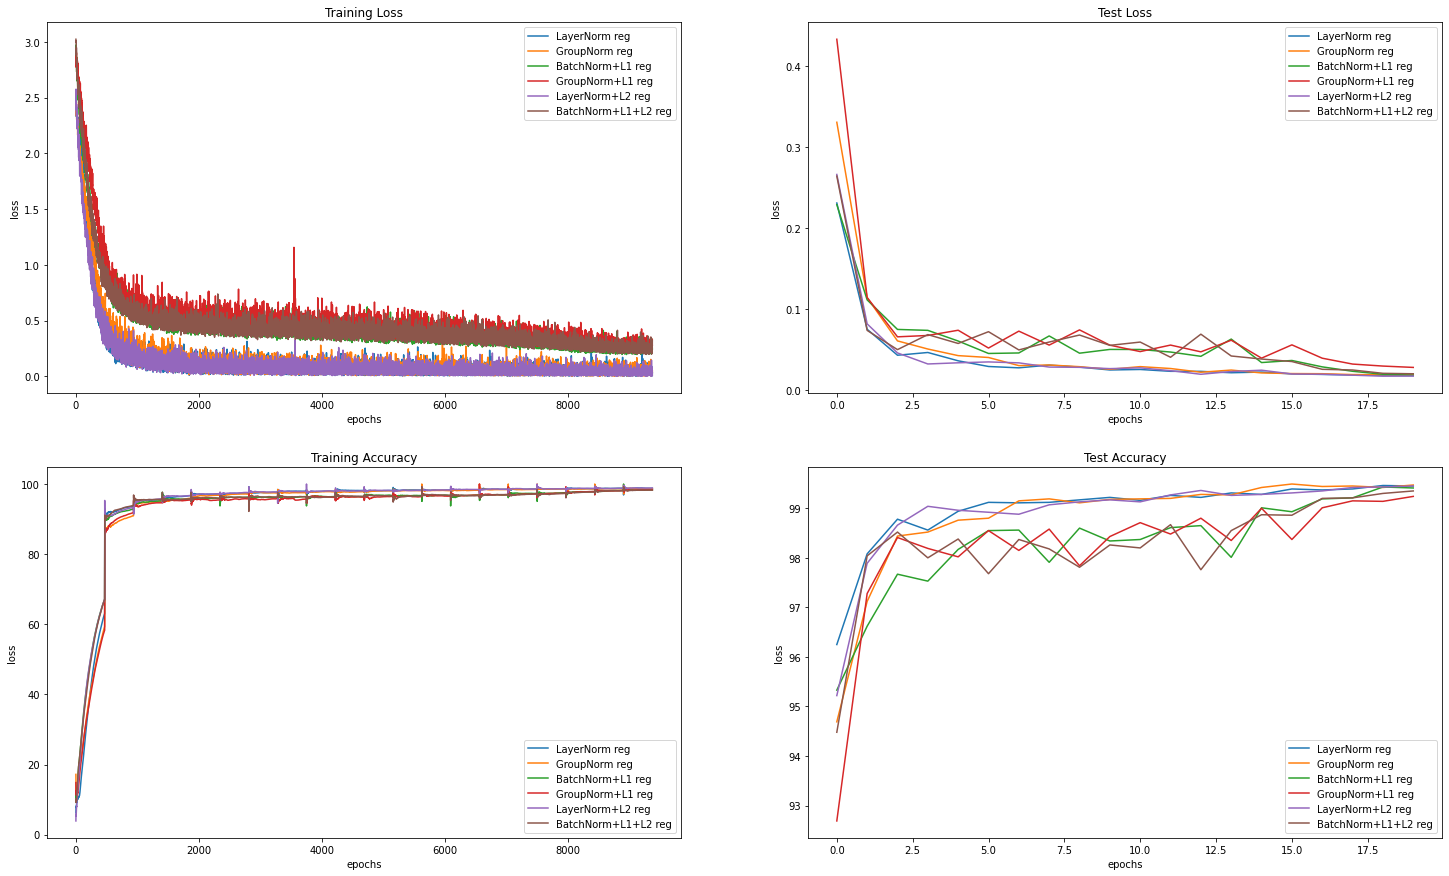

In [ ]:
plot_metrics(exp_metrics)

In [ ]:
def wrong_predictions(test_loader,model,device):
  wrong_images=[]
  wrong_label=[]
  correct_label=[]
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)        
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

      wrong_pred = (pred.eq(target.view_as(pred)) == False)
      wrong_images.append(data[wrong_pred])
      wrong_label.append(pred[wrong_pred])
      correct_label.append(target.view_as(pred)[wrong_pred])  
      
      wrong_predictions = list(zip(torch.cat(wrong_images),torch.cat(wrong_label),torch.cat(correct_label)))    
    print(f'Total wrong predictions are {len(wrong_predictions)}')
      
      
    fig = plt.figure(figsize=(8,10))
    fig.tight_layout()
    for i, (img, pred, correct) in enumerate(wrong_predictions[:10]):
          img, pred, target = img.cpu().numpy(), pred.cpu(), correct.cpu()
          ax = fig.add_subplot(5, 2, i+1)
          ax.axis('off')
          ax.set_title(f'\nactual {target.item()}\npredicted {pred.item()}',fontsize=10)  
          ax.imshow(img.squeeze(), cmap='gray_r')  
          
    plt.show()
      
  return 

Total wrong predictions are 53


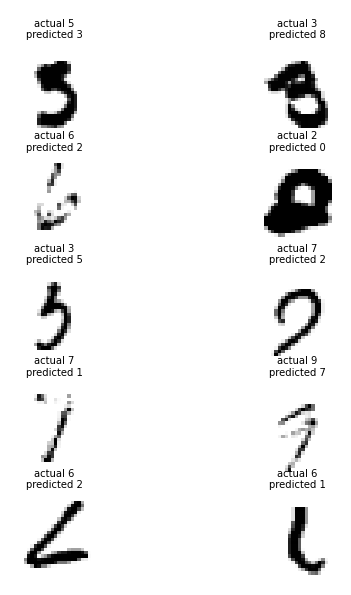

In [ ]:
model = torch.load('./GroupNorm.pt')
model.eval()
wrong_predictions(test_loader,model,device)